## Issuance of a PRC as QR code

In [126]:
# Load the private key from the PEM file
with open('private_key_ec.pem', 'rb') as f:
    private_key_pem = f.read()

In [127]:
# Compute fingerprint of private key
from helper import get_ec_private_key_fingerprint
fingerprint = get_ec_private_key_fingerprint(private_key_pem)
print("Hex-encoded fingerprint:", fingerprint)

Hex-encoded fingerprint: 3e47b334052d2575f1943c8af41026580810f88c30a236db0ef19bdd8a5d92a2


### EHIC data sample

In [128]:
sample_ehic_data = {
    "ic": "BE",
    "hn": {
        "fn": "Clément-Lafarge",
        "gn": "Jean-Pierre, Frédéric",
    },
    "dob": "29-02-2000",
    "hi": "0001019999",
    "ii": "0216X",
    "in": "LAMUTUALITENEUTRE",
    "ci": "021XXXXXXX2023035407",
    "sd": "28-02-2023",
    "ed": "29-02-2024",
    "id": "31-01-2024"
}
print("Approx. byte size:", len(str(sample_ehic_data)))

Approx. byte size: 249


### Create payload of verifiable credential
The credentialSubject is the actual EHIC data sample

In [129]:
verifiable_credential = {
    "@context": [
        "https://www.w3.org/2018/credentials/v1",
        "https://w3id.org/vc/status-list/2021/v1"
    ],
    "type": [
        "VerifiableCredential",
        "EHICCredential"
    ],
    "credentialSubject": sample_ehic_data,
    "credentialSchema": {
        "id": "https://api-pilot.ebsi.eu/trusted-schemas-registry/v3/schemas/0xfa899fd2bc2a5a66ad51f9881813401ebe02f7dd40b0926c3e49c9514a77cb6a",
        "type": "FullJsonSchemaValidator2021"
    }
}
print("Approx. byte size:", len(str(verifiable_credential)))

Approx. byte size: 622


### Build JSON web token

In [130]:
import jwt
import datetime
import json

# Define the content of the JWT
payload = {
    "iat": int(datetime.datetime.now().timestamp()),  # Issued at
    "nbf": int(datetime.datetime.now().timestamp()),  # Not before
    "exp": int((datetime.datetime.now() + datetime.timedelta(days=365)).timestamp()), # Expiration date
    "vc": verifiable_credential,
    "iss": f"ESSI:BE:0100:{fingerprint}", # Issuer
}

print(json.dumps(payload, indent=4))
print("Approx. byte size:", len(str(payload)))

{
    "iat": 1741196459,
    "nbf": 1741196459,
    "exp": 1772732459,
    "vc": {
        "@context": [
            "https://www.w3.org/2018/credentials/v1",
            "https://w3id.org/vc/status-list/2021/v1"
        ],
        "type": [
            "VerifiableCredential",
            "EHICCredential"
        ],
        "credentialSubject": {
            "ic": "BE",
            "hn": {
                "fn": "Cl\u00e9ment-Lafarge",
                "gn": "Jean-Pierre, Fr\u00e9d\u00e9ric"
            },
            "dob": "29-02-2000",
            "hi": "0001019999",
            "ii": "0216X",
            "in": "LAMUTUALITENEUTRE",
            "ci": "021XXXXXXX2023035407",
            "sd": "28-02-2023",
            "ed": "29-02-2024",
            "id": "31-01-2024"
        },
        "credentialSchema": {
            "id": "https://api-pilot.ebsi.eu/trusted-schemas-registry/v3/schemas/0xfa899fd2bc2a5a66ad51f9881813401ebe02f7dd40b0926c3e49c9514a77cb6a",
            "type": "FullJsonSc

### Sign JWT

In [131]:
encoded_jws = jwt.encode(payload, private_key_pem, algorithm='ES256')
print("Encoded JWS (JWT):", encoded_jws)
print("Approx. byte size:", len(encoded_jws))

Encoded JWS (JWT): eyJhbGciOiJFUzI1NiIsInR5cCI6IkpXVCJ9.eyJpYXQiOjE3NDExOTY0NTksIm5iZiI6MTc0MTE5NjQ1OSwiZXhwIjoxNzcyNzMyNDU5LCJ2YyI6eyJAY29udGV4dCI6WyJodHRwczovL3d3dy53My5vcmcvMjAxOC9jcmVkZW50aWFscy92MSIsImh0dHBzOi8vdzNpZC5vcmcvdmMvc3RhdHVzLWxpc3QvMjAyMS92MSJdLCJ0eXBlIjpbIlZlcmlmaWFibGVDcmVkZW50aWFsIiwiRUhJQ0NyZWRlbnRpYWwiXSwiY3JlZGVudGlhbFN1YmplY3QiOnsiaWMiOiJCRSIsImhuIjp7ImZuIjoiQ2xcdTAwZTltZW50LUxhZmFyZ2UiLCJnbiI6IkplYW4tUGllcnJlLCBGclx1MDBlOWRcdTAwZTlyaWMifSwiZG9iIjoiMjktMDItMjAwMCIsImhpIjoiMDAwMTAxOTk5OSIsImlpIjoiMDIxNlgiLCJpbiI6IkxBTVVUVUFMSVRFTkVVVFJFIiwiY2kiOiIwMjFYWFhYWFhYMjAyMzAzNTQwNyIsInNkIjoiMjgtMDItMjAyMyIsImVkIjoiMjktMDItMjAyNCIsImlkIjoiMzEtMDEtMjAyNCJ9LCJjcmVkZW50aWFsU2NoZW1hIjp7ImlkIjoiaHR0cHM6Ly9hcGktcGlsb3QuZWJzaS5ldS90cnVzdGVkLXNjaGVtYXMtcmVnaXN0cnkvdjMvc2NoZW1hcy8weGZhODk5ZmQyYmMyYTVhNjZhZDUxZjk4ODE4MTM0MDFlYmUwMmY3ZGQ0MGIwOTI2YzNlNDljOTUxNGE3N2NiNmEiLCJ0eXBlIjoiRnVsbEpzb25TY2hlbWFWYWxpZGF0b3IyMDIxIn19LCJpc3MiOiJFU1NJOkJFOjAxMDA6M2U0N2IzMzQwNTJkMjU3NWYxOTQzYzhhZjQx

### Generate QR code

Compress encoded JWS using ZLib

In [132]:
import zlib
import base64

# Compress the JWS using zlib
compressed_jws = zlib.compress(encoded_jws.encode('utf-8'))

compressed_jws_b64 = base64.b64encode(compressed_jws).decode('utf-8')
print("Compressed JWS (base64):", compressed_jws_b64)
print("Approx. byte size:", len(compressed_jws))

Compressed JWS (base64): eJxdU123ojgQ/EW7B0Hc4VFFMKwJC4ZA8ibBvQkEZEavkPz6CXrn7MeDh2NDV1VXV191IuqYy1QmUWHACklwB0Pu8z3YgG6syD4Jfr/qZKRVJtP24KHwMKeYOgh3d9D7kkmwgZg7EB981Gar9DxJVokJtLcZGa6RgRqFhX/aJy7VYGOxttQNPpuYrBtLUurk1hzziZvb8+Q1XqN9D2r/yXv+hO12TvdBy3vSsdJ3LmV05zpw4dmK7IXTHHcmld+ejUEj2797mh4+uZeL5kjMqZxH7mULjobnpS9prA7nWu0UaMcaKKZ4r3qLK+uYhP/mAXKSeSGSzEGalbmqh3yk5SQrOx/1EsViYmdQoo7Qivajop71Z7jLSwkXM/f5W+On5fkD9Mw+bzJzZ97g7cSweiw8p2IWrI80cwtpdQ21fJmuaLl+FLFSfEjUab+LuZpXMNyptMx/9euF5+/F6ziQCzZsuwcMwcPOOsH9i3t81UP7H1sfceenL03qqw5mpD4W3vHNO+8wIQUpIngmeYQ7QkiURIsP1O3sTGCCbUTLSLx+L0/N1iCcTUgvoUHdW8fHLx0aLnXr6f/0afTSp951c7D1w1c9Caye/+y7cNGNlSvx9vHdcznmDj/CzUkHgsfdg8fqXnvZJysTczn7qjkHDh+IsRnrThVqLzF50Ao+LO5wqZB91z2b1ubkC5vrb9M1ZiINO5/1maY91BQTgVomWFjMrO3WaXhYQwwdGEaK9sUEe+qxOHNgDKYUA5capFCo2hQXM4rtnbhIov4g/8nbTeYDudeH0dSuj6krVF1GJbUZZXHk1B7Qy07AsFo8sLmF76NcoSTtkii1t2B3uYFu4SAXGGis7zjpYFt4qKR2v5mhRgjWZvY74CL8MVnNE2s/1tTAiWJgUJ9LGJMeYmVzk63tjF2KEwGlPfLmCX/ATfuYrvh7qm/PNUvx3b/lY+iL+ZaQfXf9Lfg8ryo

Encode the compressed data using Base45

In [133]:
import base45

base45_encoded = base45.b45encode(compressed_jws)
print("Base45 encoded JWS:", base45_encoded)
print("Approx. byte size:", len(base45_encoded))

Base45 encoded JWS: b'6BF-ZB6%B%MKS62V 8C-0P-RFCA+66K61X/GPRU7MOD61KUCY8M7:V-81HET0AP95H4N8MZA22BG EQTTWVP:$44GCND1E7EKQ8YXUTGRR:D7EP091ZBOOWCIYA$ZQ+HSIGUJ8L6F7S4F*IQ9MI5EM1BJW126ZF3:CJ*U9C9QEH3%MZ7343MKEGQ*GF7G+.4*/Q6RC45NFU17UJ4YLMN9CVT23RKZUTVJL$URX63UKV.16FWHUF9 G1/ERBVQWPRSQERQ.%52ZEKH7$OSEPHE-G.Q3M*46CSQ%H:N4E9OYLJ$-757J25TD*P2YJ96UXK1K2HW*K7GDZ*1CMB4Q2U7PB65PBF6MF%O5TCJZFWA80CNI:A4: PIOJALNY5H3%KYP4FL78:U+.O JCW8AK2IOPH+UKD4K25DNVPW61SP6PNV4ZSD3TMM0- PQ2ENQE-7SS2U/DMTQ5A7L:%2U4ILOE.ED:W1$XF82MBKNWR2BJAE99QGD*TH1NJ/76JKLG%P04VY-G1EU6XTK9IR*6:SNPR1-XOBJ7H2WMRFA/QRXVHNB:HE46LB%95SL-/C9%7D8SO.PWAU%74095N8FDGF5M7+79.T8202N3UMT9:LGGV8Z89%.F:3A63R8YJT59GHKC:RNBP1/5.D3$+E8QTJ+UY.U:9L7%EVGMCVOAW70$L-FWEVN5MQR%IMQU.PUMPEY3TW28%.PW.00CPUTGDSTPTF$.4TK2%E7HNL6+0H:3MHMSXT$V2L/5:HFCD1RU5-AE:BIL9ROVJN8T1L1GYTOVQ1-CCU1:9K4JJX 79O2*FG6%47ABY%LY4RS9FJL8NU3D-8%8VMP06UT667I6C :KJK0PG3%8ASPR:-2FPHB.J989V5W6FWQWRN3TAMNT7H-*QC7IML5SZBNY4L93-HEW Q HQ0/9BDMBU7IKNCDU/VB3U4LLIY/MZ8CEKNZ0EP24%33 %LY8778CIBF

Generate QR code

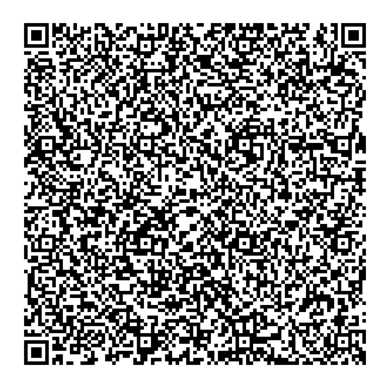

In [134]:
import qrcode
import matplotlib.pyplot as plt

# Create a QR code instance
qr = qrcode.QRCode(
    version=1,  # Controls the size of the QR Code
    error_correction=qrcode.constants.ERROR_CORRECT_L,
    box_size=10,
    border=4,
)

qr.add_data(base45_encoded)
qr.make(fit=True)

# Create an image from the QR code instance
img = qr.make_image(fill='black', back_color='white')
img.save("qrcode.png")


# Display the image in the notebook
plt.imshow(img, cmap='gray')
plt.axis('off')  # Hide the axis
plt.show()

### Make a PDF

In [135]:
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.lib.utils import ImageReader


# Create a canvas object
c = canvas.Canvas("prc.pdf", pagesize=A4)
width, height = A4

# Set font and size for the text
c.setFont("Helvetica", 12)

# Add text element of EHIC data
i = 0
for key, value in sample_ehic_data.items():
    i += 1
    c.drawString(100, height - 100 - 20 * i, f'{key}: {value}')

# Add QR code to PDF
y_position = height - 320 - 20 * i
img = ImageReader("qrcode.png")
c.drawImage(img, 100, y_position, width=200, height=200, mask='auto')

# Save the PDF file
c.save()